In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import shutil
from itertools import chain
from torchvision.transforms import Compose
import torch.nn.functional as F
import transformers



from PIL import Image
import time
from tqdm.notebook import tqdm

from pathlib import Path
import matplotlib.pyplot as plt
from torchvision.transforms import RandomVerticalFlip,RandomHorizontalFlip,Normalize,ToTensor,Resize,RandomRotation,InterpolationMode
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader


In [2]:
# data_path = Path.cwd()
# shutil.unpack_archive(data_path / Path("data.zip"), data_path)


In [2]:
class rellis_dataset(Dataset):
    """
    Using 6 classes
    """
    def __init__(self, data_root_dir, txt_file, transform=None, target_transform=None):
        """
        data_root_dit: root directory of the dataset, e.g. './data/rellis'
        txt_file: path to the train.txt listing image files
        
        """
        self.data_root_dir = data_root_dir
        self.transform = transform
        self.target_transform = target_transform
        with open(txt_file, 'r') as f:
            self.image_paths = [line.strip() for line in f.readlines()]
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.data_root_dir, 'image', self.image_paths[index] + '.jpg')
        ann_path = os.path.join(self.data_root_dir, 'annotation', self.image_paths[index] + '_group6.png')
        image = Image.open(img_path).convert('RGB')
        annotation = Image.open(ann_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            annotation = self.target_transform(annotation)
        annotation = (annotation*256).long() # turn the label to the interger
        
        annotation=(nn.functional.one_hot(annotation,6))
        annotation = np.transpose(annotation, (0,3,1,2))
        # print(annotation.shape)
        return image, annotation

In [3]:
transform = Compose([Resize((256, 256),interpolation=InterpolationMode.NEAREST),
    # RandomHorizontalFlip(),
    # RandomVerticalFlip(),
    # RandomRotation(30),                
    ToTensor()
                       ])
target_transform = Compose([Resize((256, 256),interpolation=InterpolationMode.NEAREST),
    # RandomHorizontalFlip(),
    RandomVerticalFlip(),
    # RandomRotation(30),                
    ToTensor()
                       ])
example_dataset= rellis_dataset(data_root_dir='./data/rellis', txt_file='./data/rellis/val.txt', transform=transform, target_transform=transform)
number_of_samples = len(example_dataset)


print(f"The number of samples is: {number_of_samples}")


The number of samples is: 983


In [5]:
# def display_image(axis, image_tensor,ann_tensor):
#     """Display a tensor as an image

#     Args:
#         axis (pyplot axis)
#         image_tensor (torch.Tensor): tensor with shape (num_channels=3, width, heigth)
#     """

#     # See hint above
#     if not isinstance(image_tensor, torch.Tensor):
#         raise TypeError(
#             "The `display_image` function expects a `torch.Tensor` "
#             + "use the `ToTensor` transformation to convert the images to tensors."
#         )

#     # The imshow commands expects a `numpy array` with shape (3, width, height)
#     # We rearrange the dimensions with `permute` and then convert it to `numpy`
#     image_data = image_tensor.permute(1, 2, 0).numpy()
#     ann_data = ann_tensor.permute(1, 2, 0).numpy()
#     height, width, _ = image_data.shape
#     axis.imshow(image_data)
#     axis.imshow(ann_data, alpha=0.6)
#     axis.set_xlim(0, width)
#     # By convention when working with images, the origin is at the top left corner.
#     # Therefore, we switch the order of the y limits.
#     axis.set_ylim(height, 0)


# # Example usage
# _, axis = plt.subplots()
# some_random_index = 453
# # Here we use the __getitem__ method as a "magic" method.
# # Implementing it for a class, enables square bracket '[]' indexing
# image_tensor,annotation = example_dataset[some_random_index]

# display_image(axis, image_tensor,annotation)
# print(nn.functional.one_hot(annotation,6).shape)
# print(image_tensor.shape)

dataset

In [4]:
NUM_GPUS = torch.cuda.device_count()
if NUM_GPUS > 1:
    model = torch.nn.DataParallel(model)

batch_size = 128

transforms_1 = Compose([Resize((256, 256),interpolation=InterpolationMode.NEAREST),
    # RandomHorizontalFlip(),
    # RandomVerticalFlip(),
    # RandomRotation(30),                
    ToTensor()
                       ])

transforms_2 = Compose([Resize((256, 256),interpolation=InterpolationMode.NEAREST),
    # RandomRotation(30),                
    ToTensor()
                       ])

train_dir = './train'
train_dataset= rellis_dataset(data_root_dir='./data/rellis', txt_file='./data/rellis/train.txt', transform=transforms_1, target_transform=transforms_1)

val_dir = './val'
val_dataset= rellis_dataset(data_root_dir='./data/rellis', txt_file='./data/rellis/val.txt', transform=transforms_2, target_transform=transforms_2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers = NUM_GPUS)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,num_workers = NUM_GPUS)

CNN Block

Encoder Block

Decoder block

model

In [5]:
class DownConv2(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mp = nn.MaxPool2d(kernel_size=2, return_indices=True)

    def forward(self, x):
        y = self.seq(x)
        pool_shape = y.shape
        y, indices = self.mp(y)
        return y, indices, pool_shape

class DownConv3(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mp = nn.MaxPool2d(kernel_size=2, return_indices=True)

    def forward(self, x):
        y = self.seq(x)
        pool_shape = y.shape
        y, indices = self.mp(y)
        return y, indices, pool_shape

class UpConv2(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mup = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x, indices, output_size):
        y = self.mup(x, indices, output_size=output_size)
        y = self.seq(y)
        return y

class UpConv3(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mup = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x, indices, output_size):
        y = self.mup(x, indices, output_size=output_size)
        y = self.seq(y)
        return y


class ImageSegmentation(torch.nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.out_channels = 6
        self.bn_input = nn.BatchNorm2d(3)
        self.dc1 = DownConv2(3, 12, kernel_size=kernel_size)
        # self.dc2 = DownConv2(12, 24, kernel_size=kernel_size)
        # self.dc3 = DownConv3(20, 50, kernel_size=kernel_size)
        # self.dc4 = DownConv3(50, 100, kernel_size=kernel_size)
        self.dc5 = DownConv3(12, 12, kernel_size=kernel_size)

        self.uc5 = UpConv3(12, 12, kernel_size=kernel_size)
        # self.uc4 = UpConv3(100, 50, kernel_size=kernel_size)
        # self.uc3 = UpConv3(50, 20, kernel_size=kernel_size)
        # self.uc2 = UpConv2(24, 12, kernel_size=kernel_size)
        self.uc1 = UpConv2(12, 6, kernel_size=kernel_size)

    def forward(self, batch: torch.Tensor):
        x = self.bn_input(batch)
        # x = batch
        # Encoder
        x, mp1_indices, shape1 = self.dc1(x)
        # x, mp2_indices, shape2 = self.dc2(x)
        # x, mp3_indices, shape3 = self.dc3(x)
        # x, mp4_indices, shape4 = self.dc4(x)
        x, mp5_indices, shape5 = self.dc5(x)

        # Decoder
        x = self.uc5(x, mp5_indices, output_size=shape5)
        # x = self.uc4(x, mp4_indices, output_size=shape4)
        # x = self.uc3(x, mp3_indices, output_size=shape3)
        # x = self.uc2(x, mp2_indices, output_size=shape2)
        x = self.uc1(x, mp1_indices, output_size=shape1)

        return x
    

model=ImageSegmentation(3)
model.uc1.seq[5] = nn.Softmax(dim=1)

trainning

In [6]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=6):
    with torch.no_grad():
        # pred_mask = F.softmax(pred_mask, dim=1)
        # pred_mask = torch.argmax(pred_mask, dim=1)
        # print(pred_mask.shape)
        # print(mask.shape)
        mask=torch.argmax(mask, dim=1).squeeze(0)
        pred_mask=torch.argmax(pred_mask, dim=1).squeeze(0)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)
        # print(pred_mask.shape)
        # print(mask.shape)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)


def compute_accuracy(testDataLoader,loss_fn,model,device):

    model.eval()  
    total_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in testDataLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn.calculate_average_dice_loss(outputs, labels.squeeze(1))
            # loss = loss_fn(torch.argmax(outputs, dim=1).float(), torch.argmax(labels.squeeze(1), dim=1).float())            
            # test_accuracy += pixel_accuracy(output, mask)
            val_accuracy += mIoU(outputs, labels.squeeze(1))
            total_loss += loss.item()

    return total_loss / len(testDataLoader), val_accuracy / len(testDataLoader)

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 1.0
        # print(input.shape,target.shape)
        iflat = input.reshape(-1)
        tflat = target.reshape(-1)
        intersection = (iflat * tflat).sum()

        dice_loss = 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

        return dice_loss

    def calculate_average_dice_loss(self, inputs, targets):
        num_channels = inputs.size(1)
        # print(num_channels)

        # Calculate Dice loss for each channel
        dice_losses = []
        for channel in range(num_channels):
            input_channel = inputs[:, channel, ...].unsqueeze(1)
            target_channel = targets[:, channel, ...].unsqueeze(1)
            # print(input_channel,target_channel)
            dice_loss_channel = self.forward(input_channel, target_channel)
            dice_losses.append(dice_loss_channel)

        # Calculate average Dice loss
        average_dice_loss = torch.mean(torch.stack(dice_losses))

        return average_dice_loss
    
dice_loss=DiceLoss()

def train(model, dataloader, loss_fn, optimizer, device, ldl, lts): 
    model.train()  
    total_loss = 0
    train_accuracy = 0 

    for batch in tqdm(dataloader):
        inputs, labels = batch[0].to(device), batch[1].to(device)
        # print(inputs.shape)
        # print(outputs.shape)
        optimizer.zero_grad() 
        outputs = model(inputs)
        # print(inputs.shape)
        # print(outputs.shape)
        # print(labels.squeeze(1).shape)

        loss = loss_fn.calculate_average_dice_loss(outputs, labels.squeeze(1))
        # loss = loss_fn(torch.argmax(outputs, dim=1).float(),torch.argmax(labels.squeeze(1), dim=1).float())
        train_accuracy += mIoU(outputs, labels.squeeze(1))
        # print(train_accuracy/ldl)

        loss.backward()     
        optimizer.step()   

        total_loss += loss.item()

    return total_loss / ldl, train_accuracy / ldl

In [7]:
import torch.optim as optim


ldl = len(train_dataloader)

num_epochs = 30
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model.parameters(), lr=0.001) #,weight_decay=0.0001


if(torch.cuda.is_available()):
    device = torch.device('cuda')
elif(torch.backends.mps.is_available()):
    device = torch.device('mps')
else:
    device = torch.device('cpu')

model.to(device)

ImageSegmentation(
  (bn_input): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dc1): DownConv2(
    (seq): Sequential(
      (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dc5): DownConv3(
    (seq): Sequential(
      (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_ru

In [10]:

train_losses = []
cross_losses = []
train_acces=[]
val_acces=[]
bestScore=1

for epoch in range(num_epochs):
    train_loss,train_acc = train(model, train_dataloader,dice_loss, optimizer, device, ldl, ldl*4)
    Current_loss,val_acc = compute_accuracy(val_dataloader,dice_loss, model,device)
    #print(Current_loss)
    #print(CurrentScore)
    train_losses.append(train_loss)
    cross_losses.append(Current_loss)
    train_acces.append(train_acc)
    val_acces.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')
    print(f'Cross Acc: {Current_loss:.4f}')
    print(f'train Acc: {train_acc:.4f}')
    print(f'val Acc: {val_acc:.4f}')

    #scheduler.step()

    # initialize 3 subplots to plot the loss curve, learning rate curve and accuracy curve

    
    
    if Current_loss < bestScore:
        bestScore = Current_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')



  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1/30, Train Loss: 0.7598
Cross Acc: 0.8473
train Acc: 0.2447
val Acc: 0.0409


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2/30, Train Loss: 0.6357
Cross Acc: 0.6331
train Acc: 0.3929
val Acc: 0.3987


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3/30, Train Loss: 0.5925
Cross Acc: 0.5850
train Acc: 0.4304
val Acc: 0.4298


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4/30, Train Loss: 0.5481
Cross Acc: 0.5473
train Acc: 0.4853
val Acc: 0.4808


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5/30, Train Loss: 0.5034
Cross Acc: 0.5331
train Acc: 0.5771
val Acc: 0.5117


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6/30, Train Loss: 0.4773
Cross Acc: 0.5291
train Acc: 0.6210
val Acc: 0.5208


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7/30, Train Loss: 0.4609
Cross Acc: 0.5242
train Acc: 0.6340
val Acc: 0.5050


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8/30, Train Loss: 0.4455
Cross Acc: 0.5081
train Acc: 0.6429
val Acc: 0.5196


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9/30, Train Loss: 0.4305
Cross Acc: 0.5046
train Acc: 0.6606
val Acc: 0.5180


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10/30, Train Loss: 0.4186
Cross Acc: 0.4847
train Acc: 0.6659
val Acc: 0.5316


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 11/30, Train Loss: 0.4053
Cross Acc: 0.4778
train Acc: 0.6787
val Acc: 0.5357


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12/30, Train Loss: 0.3943
Cross Acc: 0.4805
train Acc: 0.6842
val Acc: 0.5368


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 13/30, Train Loss: 0.3808
Cross Acc: 0.4532
train Acc: 0.6968
val Acc: 0.5492


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14/30, Train Loss: 0.3699
Cross Acc: 0.4504
train Acc: 0.7007
val Acc: 0.5574


  0%|          | 0/26 [00:00<?, ?it/s]

KeyboardInterrupt: 

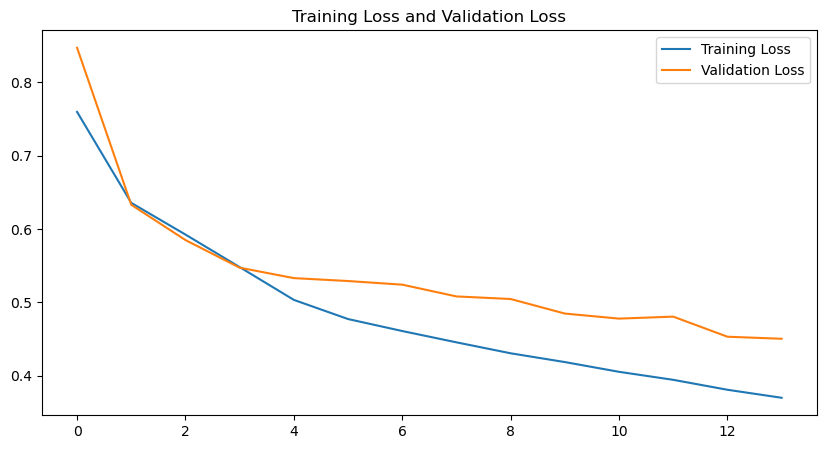

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(cross_losses, label='Validation Loss')
plt.title('Training Loss and Validation Loss')
plt.legend()
plt.show(block=False)


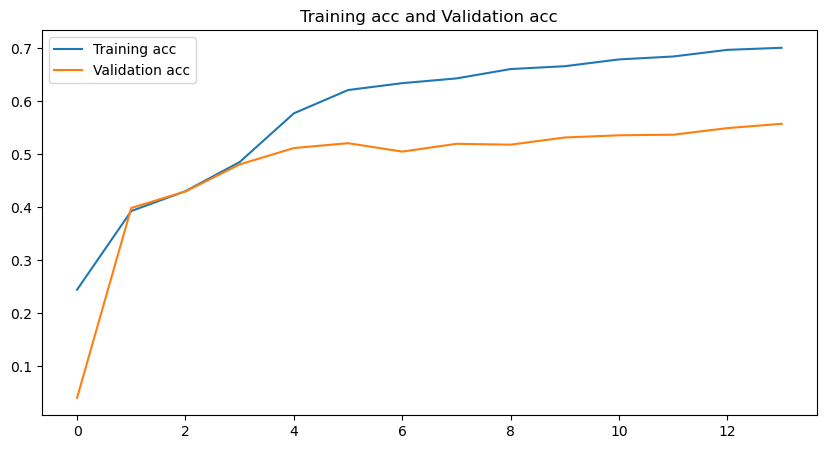

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_acces, label='Training acc')
plt.plot(val_acces, label='Validation acc')
plt.title('Training acc and Validation acc')
plt.legend()
plt.show(block=False)

In [9]:


model = ImageSegmentation(3)
model.load_state_dict(torch.load('best_model.pt', map_location=device))
image_tensor,annotation = example_dataset[763]
print(image_tensor.shape)
image_tensor1 = image_tensor.unsqueeze(0).repeat(1, 1, 1, 1)

with torch.no_grad():
    pred = model(image_tensor1)
print(pred.shape)
pred = torch.argmax(pred, dim=1).squeeze(0)
print(pred.shape)


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image_tensor.permute(1, 2, 0))
plt.title("The Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow((torch.argmax(annotation, dim=1).squeeze(0))/256)
plt.title("Real Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pred/256)
plt.title("Predicted Mask")
plt.axis('off')



/var/tmp/ipykernel_4760/1505365378.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt', map_location=device))


RuntimeError: Error(s) in loading state_dict for ImageSegmentation:
	Missing key(s) in state_dict: "bn_input.weight", "bn_input.bias", "bn_input.running_mean", "bn_input.running_var", "dc1.seq.0.weight", "dc1.seq.0.bias", "dc1.seq.1.weight", "dc1.seq.1.bias", "dc1.seq.1.running_mean", "dc1.seq.1.running_var", "dc1.seq.3.weight", "dc1.seq.3.bias", "dc1.seq.4.weight", "dc1.seq.4.bias", "dc1.seq.4.running_mean", "dc1.seq.4.running_var", "dc5.seq.0.weight", "dc5.seq.0.bias", "dc5.seq.1.weight", "dc5.seq.1.bias", "dc5.seq.1.running_mean", "dc5.seq.1.running_var", "dc5.seq.3.weight", "dc5.seq.3.bias", "dc5.seq.4.weight", "dc5.seq.4.bias", "dc5.seq.4.running_mean", "dc5.seq.4.running_var", "dc5.seq.6.weight", "dc5.seq.6.bias", "dc5.seq.7.weight", "dc5.seq.7.bias", "dc5.seq.7.running_mean", "dc5.seq.7.running_var", "uc5.seq.0.weight", "uc5.seq.0.bias", "uc5.seq.1.weight", "uc5.seq.1.bias", "uc5.seq.1.running_mean", "uc5.seq.1.running_var", "uc5.seq.3.weight", "uc5.seq.3.bias", "uc5.seq.4.weight", "uc5.seq.4.bias", "uc5.seq.4.running_mean", "uc5.seq.4.running_var", "uc5.seq.6.weight", "uc5.seq.6.bias", "uc5.seq.7.weight", "uc5.seq.7.bias", "uc5.seq.7.running_mean", "uc5.seq.7.running_var", "uc1.seq.0.weight", "uc1.seq.0.bias", "uc1.seq.1.weight", "uc1.seq.1.bias", "uc1.seq.1.running_mean", "uc1.seq.1.running_var", "uc1.seq.3.weight", "uc1.seq.3.bias", "uc1.seq.4.weight", "uc1.seq.4.bias", "uc1.seq.4.running_mean", "uc1.seq.4.running_var". 
	Unexpected key(s) in state_dict: "backbone.conv1.weight", "backbone.bn1.weight", "backbone.bn1.bias", "backbone.bn1.running_mean", "backbone.bn1.running_var", "backbone.bn1.num_batches_tracked", "backbone.layer1.0.conv1.weight", "backbone.layer1.0.bn1.weight", "backbone.layer1.0.bn1.bias", "backbone.layer1.0.bn1.running_mean", "backbone.layer1.0.bn1.running_var", "backbone.layer1.0.bn1.num_batches_tracked", "backbone.layer1.0.conv2.weight", "backbone.layer1.0.bn2.weight", "backbone.layer1.0.bn2.bias", "backbone.layer1.0.bn2.running_mean", "backbone.layer1.0.bn2.running_var", "backbone.layer1.0.bn2.num_batches_tracked", "backbone.layer1.0.conv3.weight", "backbone.layer1.0.bn3.weight", "backbone.layer1.0.bn3.bias", "backbone.layer1.0.bn3.running_mean", "backbone.layer1.0.bn3.running_var", "backbone.layer1.0.bn3.num_batches_tracked", "backbone.layer1.0.downsample.0.weight", "backbone.layer1.0.downsample.1.weight", "backbone.layer1.0.downsample.1.bias", "backbone.layer1.0.downsample.1.running_mean", "backbone.layer1.0.downsample.1.running_var", "backbone.layer1.0.downsample.1.num_batches_tracked", "backbone.layer1.1.conv1.weight", "backbone.layer1.1.bn1.weight", "backbone.layer1.1.bn1.bias", "backbone.layer1.1.bn1.running_mean", "backbone.layer1.1.bn1.running_var", "backbone.layer1.1.bn1.num_batches_tracked", "backbone.layer1.1.conv2.weight", "backbone.layer1.1.bn2.weight", "backbone.layer1.1.bn2.bias", "backbone.layer1.1.bn2.running_mean", "backbone.layer1.1.bn2.running_var", "backbone.layer1.1.bn2.num_batches_tracked", "backbone.layer1.1.conv3.weight", "backbone.layer1.1.bn3.weight", "backbone.layer1.1.bn3.bias", "backbone.layer1.1.bn3.running_mean", "backbone.layer1.1.bn3.running_var", "backbone.layer1.1.bn3.num_batches_tracked", "backbone.layer1.2.conv1.weight", "backbone.layer1.2.bn1.weight", "backbone.layer1.2.bn1.bias", "backbone.layer1.2.bn1.running_mean", "backbone.layer1.2.bn1.running_var", "backbone.layer1.2.bn1.num_batches_tracked", "backbone.layer1.2.conv2.weight", "backbone.layer1.2.bn2.weight", "backbone.layer1.2.bn2.bias", "backbone.layer1.2.bn2.running_mean", "backbone.layer1.2.bn2.running_var", "backbone.layer1.2.bn2.num_batches_tracked", "backbone.layer1.2.conv3.weight", "backbone.layer1.2.bn3.weight", "backbone.layer1.2.bn3.bias", "backbone.layer1.2.bn3.running_mean", "backbone.layer1.2.bn3.running_var", "backbone.layer1.2.bn3.num_batches_tracked", "backbone.layer2.0.conv1.weight", "backbone.layer2.0.bn1.weight", "backbone.layer2.0.bn1.bias", "backbone.layer2.0.bn1.running_mean", "backbone.layer2.0.bn1.running_var", "backbone.layer2.0.bn1.num_batches_tracked", "backbone.layer2.0.conv2.weight", "backbone.layer2.0.bn2.weight", "backbone.layer2.0.bn2.bias", "backbone.layer2.0.bn2.running_mean", "backbone.layer2.0.bn2.running_var", "backbone.layer2.0.bn2.num_batches_tracked", "backbone.layer2.0.conv3.weight", "backbone.layer2.0.bn3.weight", "backbone.layer2.0.bn3.bias", "backbone.layer2.0.bn3.running_mean", "backbone.layer2.0.bn3.running_var", "backbone.layer2.0.bn3.num_batches_tracked", "backbone.layer2.0.downsample.0.weight", "backbone.layer2.0.downsample.1.weight", "backbone.layer2.0.downsample.1.bias", "backbone.layer2.0.downsample.1.running_mean", "backbone.layer2.0.downsample.1.running_var", "backbone.layer2.0.downsample.1.num_batches_tracked", "backbone.layer2.1.conv1.weight", "backbone.layer2.1.bn1.weight", "backbone.layer2.1.bn1.bias", "backbone.layer2.1.bn1.running_mean", "backbone.layer2.1.bn1.running_var", "backbone.layer2.1.bn1.num_batches_tracked", "backbone.layer2.1.conv2.weight", "backbone.layer2.1.bn2.weight", "backbone.layer2.1.bn2.bias", "backbone.layer2.1.bn2.running_mean", "backbone.layer2.1.bn2.running_var", "backbone.layer2.1.bn2.num_batches_tracked", "backbone.layer2.1.conv3.weight", "backbone.layer2.1.bn3.weight", "backbone.layer2.1.bn3.bias", "backbone.layer2.1.bn3.running_mean", "backbone.layer2.1.bn3.running_var", "backbone.layer2.1.bn3.num_batches_tracked", "backbone.layer2.2.conv1.weight", "backbone.layer2.2.bn1.weight", "backbone.layer2.2.bn1.bias", "backbone.layer2.2.bn1.running_mean", "backbone.layer2.2.bn1.running_var", "backbone.layer2.2.bn1.num_batches_tracked", "backbone.layer2.2.conv2.weight", "backbone.layer2.2.bn2.weight", "backbone.layer2.2.bn2.bias", "backbone.layer2.2.bn2.running_mean", "backbone.layer2.2.bn2.running_var", "backbone.layer2.2.bn2.num_batches_tracked", "backbone.layer2.2.conv3.weight", "backbone.layer2.2.bn3.weight", "backbone.layer2.2.bn3.bias", "backbone.layer2.2.bn3.running_mean", "backbone.layer2.2.bn3.running_var", "backbone.layer2.2.bn3.num_batches_tracked", "backbone.layer2.3.conv1.weight", "backbone.layer2.3.bn1.weight", "backbone.layer2.3.bn1.bias", "backbone.layer2.3.bn1.running_mean", "backbone.layer2.3.bn1.running_var", "backbone.layer2.3.bn1.num_batches_tracked", "backbone.layer2.3.conv2.weight", "backbone.layer2.3.bn2.weight", "backbone.layer2.3.bn2.bias", "backbone.layer2.3.bn2.running_mean", "backbone.layer2.3.bn2.running_var", "backbone.layer2.3.bn2.num_batches_tracked", "backbone.layer2.3.conv3.weight", "backbone.layer2.3.bn3.weight", "backbone.layer2.3.bn3.bias", "backbone.layer2.3.bn3.running_mean", "backbone.layer2.3.bn3.running_var", "backbone.layer2.3.bn3.num_batches_tracked", "backbone.layer3.0.conv1.weight", "backbone.layer3.0.bn1.weight", "backbone.layer3.0.bn1.bias", "backbone.layer3.0.bn1.running_mean", "backbone.layer3.0.bn1.running_var", "backbone.layer3.0.bn1.num_batches_tracked", "backbone.layer3.0.conv2.weight", "backbone.layer3.0.bn2.weight", "backbone.layer3.0.bn2.bias", "backbone.layer3.0.bn2.running_mean", "backbone.layer3.0.bn2.running_var", "backbone.layer3.0.bn2.num_batches_tracked", "backbone.layer3.0.conv3.weight", "backbone.layer3.0.bn3.weight", "backbone.layer3.0.bn3.bias", "backbone.layer3.0.bn3.running_mean", "backbone.layer3.0.bn3.running_var", "backbone.layer3.0.bn3.num_batches_tracked", "backbone.layer3.0.downsample.0.weight", "backbone.layer3.0.downsample.1.weight", "backbone.layer3.0.downsample.1.bias", "backbone.layer3.0.downsample.1.running_mean", "backbone.layer3.0.downsample.1.running_var", "backbone.layer3.0.downsample.1.num_batches_tracked", "backbone.layer3.1.conv1.weight", "backbone.layer3.1.bn1.weight", "backbone.layer3.1.bn1.bias", "backbone.layer3.1.bn1.running_mean", "backbone.layer3.1.bn1.running_var", "backbone.layer3.1.bn1.num_batches_tracked", "backbone.layer3.1.conv2.weight", "backbone.layer3.1.bn2.weight", "backbone.layer3.1.bn2.bias", "backbone.layer3.1.bn2.running_mean", "backbone.layer3.1.bn2.running_var", "backbone.layer3.1.bn2.num_batches_tracked", "backbone.layer3.1.conv3.weight", "backbone.layer3.1.bn3.weight", "backbone.layer3.1.bn3.bias", "backbone.layer3.1.bn3.running_mean", "backbone.layer3.1.bn3.running_var", "backbone.layer3.1.bn3.num_batches_tracked", "backbone.layer3.2.conv1.weight", "backbone.layer3.2.bn1.weight", "backbone.layer3.2.bn1.bias", "backbone.layer3.2.bn1.running_mean", "backbone.layer3.2.bn1.running_var", "backbone.layer3.2.bn1.num_batches_tracked", "backbone.layer3.2.conv2.weight", "backbone.layer3.2.bn2.weight", "backbone.layer3.2.bn2.bias", "backbone.layer3.2.bn2.running_mean", "backbone.layer3.2.bn2.running_var", "backbone.layer3.2.bn2.num_batches_tracked", "backbone.layer3.2.conv3.weight", "backbone.layer3.2.bn3.weight", "backbone.layer3.2.bn3.bias", "backbone.layer3.2.bn3.running_mean", "backbone.layer3.2.bn3.running_var", "backbone.layer3.2.bn3.num_batches_tracked", "backbone.layer3.3.conv1.weight", "backbone.layer3.3.bn1.weight", "backbone.layer3.3.bn1.bias", "backbone.layer3.3.bn1.running_mean", "backbone.layer3.3.bn1.running_var", "backbone.layer3.3.bn1.num_batches_tracked", "backbone.layer3.3.conv2.weight", "backbone.layer3.3.bn2.weight", "backbone.layer3.3.bn2.bias", "backbone.layer3.3.bn2.running_mean", "backbone.layer3.3.bn2.running_var", "backbone.layer3.3.bn2.num_batches_tracked", "backbone.layer3.3.conv3.weight", "backbone.layer3.3.bn3.weight", "backbone.layer3.3.bn3.bias", "backbone.layer3.3.bn3.running_mean", "backbone.layer3.3.bn3.running_var", "backbone.layer3.3.bn3.num_batches_tracked", "backbone.layer3.4.conv1.weight", "backbone.layer3.4.bn1.weight", "backbone.layer3.4.bn1.bias", "backbone.layer3.4.bn1.running_mean", "backbone.layer3.4.bn1.running_var", "backbone.layer3.4.bn1.num_batches_tracked", "backbone.layer3.4.conv2.weight", "backbone.layer3.4.bn2.weight", "backbone.layer3.4.bn2.bias", "backbone.layer3.4.bn2.running_mean", "backbone.layer3.4.bn2.running_var", "backbone.layer3.4.bn2.num_batches_tracked", "backbone.layer3.4.conv3.weight", "backbone.layer3.4.bn3.weight", "backbone.layer3.4.bn3.bias", "backbone.layer3.4.bn3.running_mean", "backbone.layer3.4.bn3.running_var", "backbone.layer3.4.bn3.num_batches_tracked", "backbone.layer3.5.conv1.weight", "backbone.layer3.5.bn1.weight", "backbone.layer3.5.bn1.bias", "backbone.layer3.5.bn1.running_mean", "backbone.layer3.5.bn1.running_var", "backbone.layer3.5.bn1.num_batches_tracked", "backbone.layer3.5.conv2.weight", "backbone.layer3.5.bn2.weight", "backbone.layer3.5.bn2.bias", "backbone.layer3.5.bn2.running_mean", "backbone.layer3.5.bn2.running_var", "backbone.layer3.5.bn2.num_batches_tracked", "backbone.layer3.5.conv3.weight", "backbone.layer3.5.bn3.weight", "backbone.layer3.5.bn3.bias", "backbone.layer3.5.bn3.running_mean", "backbone.layer3.5.bn3.running_var", "backbone.layer3.5.bn3.num_batches_tracked", "backbone.layer3.6.conv1.weight", "backbone.layer3.6.bn1.weight", "backbone.layer3.6.bn1.bias", "backbone.layer3.6.bn1.running_mean", "backbone.layer3.6.bn1.running_var", "backbone.layer3.6.bn1.num_batches_tracked", "backbone.layer3.6.conv2.weight", "backbone.layer3.6.bn2.weight", "backbone.layer3.6.bn2.bias", "backbone.layer3.6.bn2.running_mean", "backbone.layer3.6.bn2.running_var", "backbone.layer3.6.bn2.num_batches_tracked", "backbone.layer3.6.conv3.weight", "backbone.layer3.6.bn3.weight", "backbone.layer3.6.bn3.bias", "backbone.layer3.6.bn3.running_mean", "backbone.layer3.6.bn3.running_var", "backbone.layer3.6.bn3.num_batches_tracked", "backbone.layer3.7.conv1.weight", "backbone.layer3.7.bn1.weight", "backbone.layer3.7.bn1.bias", "backbone.layer3.7.bn1.running_mean", "backbone.layer3.7.bn1.running_var", "backbone.layer3.7.bn1.num_batches_tracked", "backbone.layer3.7.conv2.weight", "backbone.layer3.7.bn2.weight", "backbone.layer3.7.bn2.bias", "backbone.layer3.7.bn2.running_mean", "backbone.layer3.7.bn2.running_var", "backbone.layer3.7.bn2.num_batches_tracked", "backbone.layer3.7.conv3.weight", "backbone.layer3.7.bn3.weight", "backbone.layer3.7.bn3.bias", "backbone.layer3.7.bn3.running_mean", "backbone.layer3.7.bn3.running_var", "backbone.layer3.7.bn3.num_batches_tracked", "backbone.layer3.8.conv1.weight", "backbone.layer3.8.bn1.weight", "backbone.layer3.8.bn1.bias", "backbone.layer3.8.bn1.running_mean", "backbone.layer3.8.bn1.running_var", "backbone.layer3.8.bn1.num_batches_tracked", "backbone.layer3.8.conv2.weight", "backbone.layer3.8.bn2.weight", "backbone.layer3.8.bn2.bias", "backbone.layer3.8.bn2.running_mean", "backbone.layer3.8.bn2.running_var", "backbone.layer3.8.bn2.num_batches_tracked", "backbone.layer3.8.conv3.weight", "backbone.layer3.8.bn3.weight", "backbone.layer3.8.bn3.bias", "backbone.layer3.8.bn3.running_mean", "backbone.layer3.8.bn3.running_var", "backbone.layer3.8.bn3.num_batches_tracked", "backbone.layer3.9.conv1.weight", "backbone.layer3.9.bn1.weight", "backbone.layer3.9.bn1.bias", "backbone.layer3.9.bn1.running_mean", "backbone.layer3.9.bn1.running_var", "backbone.layer3.9.bn1.num_batches_tracked", "backbone.layer3.9.conv2.weight", "backbone.layer3.9.bn2.weight", "backbone.layer3.9.bn2.bias", "backbone.layer3.9.bn2.running_mean", "backbone.layer3.9.bn2.running_var", "backbone.layer3.9.bn2.num_batches_tracked", "backbone.layer3.9.conv3.weight", "backbone.layer3.9.bn3.weight", "backbone.layer3.9.bn3.bias", "backbone.layer3.9.bn3.running_mean", "backbone.layer3.9.bn3.running_var", "backbone.layer3.9.bn3.num_batches_tracked", "backbone.layer3.10.conv1.weight", "backbone.layer3.10.bn1.weight", "backbone.layer3.10.bn1.bias", "backbone.layer3.10.bn1.running_mean", "backbone.layer3.10.bn1.running_var", "backbone.layer3.10.bn1.num_batches_tracked", "backbone.layer3.10.conv2.weight", "backbone.layer3.10.bn2.weight", "backbone.layer3.10.bn2.bias", "backbone.layer3.10.bn2.running_mean", "backbone.layer3.10.bn2.running_var", "backbone.layer3.10.bn2.num_batches_tracked", "backbone.layer3.10.conv3.weight", "backbone.layer3.10.bn3.weight", "backbone.layer3.10.bn3.bias", "backbone.layer3.10.bn3.running_mean", "backbone.layer3.10.bn3.running_var", "backbone.layer3.10.bn3.num_batches_tracked", "backbone.layer3.11.conv1.weight", "backbone.layer3.11.bn1.weight", "backbone.layer3.11.bn1.bias", "backbone.layer3.11.bn1.running_mean", "backbone.layer3.11.bn1.running_var", "backbone.layer3.11.bn1.num_batches_tracked", "backbone.layer3.11.conv2.weight", "backbone.layer3.11.bn2.weight", "backbone.layer3.11.bn2.bias", "backbone.layer3.11.bn2.running_mean", "backbone.layer3.11.bn2.running_var", "backbone.layer3.11.bn2.num_batches_tracked", "backbone.layer3.11.conv3.weight", "backbone.layer3.11.bn3.weight", "backbone.layer3.11.bn3.bias", "backbone.layer3.11.bn3.running_mean", "backbone.layer3.11.bn3.running_var", "backbone.layer3.11.bn3.num_batches_tracked", "backbone.layer3.12.conv1.weight", "backbone.layer3.12.bn1.weight", "backbone.layer3.12.bn1.bias", "backbone.layer3.12.bn1.running_mean", "backbone.layer3.12.bn1.running_var", "backbone.layer3.12.bn1.num_batches_tracked", "backbone.layer3.12.conv2.weight", "backbone.layer3.12.bn2.weight", "backbone.layer3.12.bn2.bias", "backbone.layer3.12.bn2.running_mean", "backbone.layer3.12.bn2.running_var", "backbone.layer3.12.bn2.num_batches_tracked", "backbone.layer3.12.conv3.weight", "backbone.layer3.12.bn3.weight", "backbone.layer3.12.bn3.bias", "backbone.layer3.12.bn3.running_mean", "backbone.layer3.12.bn3.running_var", "backbone.layer3.12.bn3.num_batches_tracked", "backbone.layer3.13.conv1.weight", "backbone.layer3.13.bn1.weight", "backbone.layer3.13.bn1.bias", "backbone.layer3.13.bn1.running_mean", "backbone.layer3.13.bn1.running_var", "backbone.layer3.13.bn1.num_batches_tracked", "backbone.layer3.13.conv2.weight", "backbone.layer3.13.bn2.weight", "backbone.layer3.13.bn2.bias", "backbone.layer3.13.bn2.running_mean", "backbone.layer3.13.bn2.running_var", "backbone.layer3.13.bn2.num_batches_tracked", "backbone.layer3.13.conv3.weight", "backbone.layer3.13.bn3.weight", "backbone.layer3.13.bn3.bias", "backbone.layer3.13.bn3.running_mean", "backbone.layer3.13.bn3.running_var", "backbone.layer3.13.bn3.num_batches_tracked", "backbone.layer3.14.conv1.weight", "backbone.layer3.14.bn1.weight", "backbone.layer3.14.bn1.bias", "backbone.layer3.14.bn1.running_mean", "backbone.layer3.14.bn1.running_var", "backbone.layer3.14.bn1.num_batches_tracked", "backbone.layer3.14.conv2.weight", "backbone.layer3.14.bn2.weight", "backbone.layer3.14.bn2.bias", "backbone.layer3.14.bn2.running_mean", "backbone.layer3.14.bn2.running_var", "backbone.layer3.14.bn2.num_batches_tracked", "backbone.layer3.14.conv3.weight", "backbone.layer3.14.bn3.weight", "backbone.layer3.14.bn3.bias", "backbone.layer3.14.bn3.running_mean", "backbone.layer3.14.bn3.running_var", "backbone.layer3.14.bn3.num_batches_tracked", "backbone.layer3.15.conv1.weight", "backbone.layer3.15.bn1.weight", "backbone.layer3.15.bn1.bias", "backbone.layer3.15.bn1.running_mean", "backbone.layer3.15.bn1.running_var", "backbone.layer3.15.bn1.num_batches_tracked", "backbone.layer3.15.conv2.weight", "backbone.layer3.15.bn2.weight", "backbone.layer3.15.bn2.bias", "backbone.layer3.15.bn2.running_mean", "backbone.layer3.15.bn2.running_var", "backbone.layer3.15.bn2.num_batches_tracked", "backbone.layer3.15.conv3.weight", "backbone.layer3.15.bn3.weight", "backbone.layer3.15.bn3.bias", "backbone.layer3.15.bn3.running_mean", "backbone.layer3.15.bn3.running_var", "backbone.layer3.15.bn3.num_batches_tracked", "backbone.layer3.16.conv1.weight", "backbone.layer3.16.bn1.weight", "backbone.layer3.16.bn1.bias", "backbone.layer3.16.bn1.running_mean", "backbone.layer3.16.bn1.running_var", "backbone.layer3.16.bn1.num_batches_tracked", "backbone.layer3.16.conv2.weight", "backbone.layer3.16.bn2.weight", "backbone.layer3.16.bn2.bias", "backbone.layer3.16.bn2.running_mean", "backbone.layer3.16.bn2.running_var", "backbone.layer3.16.bn2.num_batches_tracked", "backbone.layer3.16.conv3.weight", "backbone.layer3.16.bn3.weight", "backbone.layer3.16.bn3.bias", "backbone.layer3.16.bn3.running_mean", "backbone.layer3.16.bn3.running_var", "backbone.layer3.16.bn3.num_batches_tracked", "backbone.layer3.17.conv1.weight", "backbone.layer3.17.bn1.weight", "backbone.layer3.17.bn1.bias", "backbone.layer3.17.bn1.running_mean", "backbone.layer3.17.bn1.running_var", "backbone.layer3.17.bn1.num_batches_tracked", "backbone.layer3.17.conv2.weight", "backbone.layer3.17.bn2.weight", "backbone.layer3.17.bn2.bias", "backbone.layer3.17.bn2.running_mean", "backbone.layer3.17.bn2.running_var", "backbone.layer3.17.bn2.num_batches_tracked", "backbone.layer3.17.conv3.weight", "backbone.layer3.17.bn3.weight", "backbone.layer3.17.bn3.bias", "backbone.layer3.17.bn3.running_mean", "backbone.layer3.17.bn3.running_var", "backbone.layer3.17.bn3.num_batches_tracked", "backbone.layer3.18.conv1.weight", "backbone.layer3.18.bn1.weight", "backbone.layer3.18.bn1.bias", "backbone.layer3.18.bn1.running_mean", "backbone.layer3.18.bn1.running_var", "backbone.layer3.18.bn1.num_batches_tracked", "backbone.layer3.18.conv2.weight", "backbone.layer3.18.bn2.weight", "backbone.layer3.18.bn2.bias", "backbone.layer3.18.bn2.running_mean", "backbone.layer3.18.bn2.running_var", "backbone.layer3.18.bn2.num_batches_tracked", "backbone.layer3.18.conv3.weight", "backbone.layer3.18.bn3.weight", "backbone.layer3.18.bn3.bias", "backbone.layer3.18.bn3.running_mean", "backbone.layer3.18.bn3.running_var", "backbone.layer3.18.bn3.num_batches_tracked", "backbone.layer3.19.conv1.weight", "backbone.layer3.19.bn1.weight", "backbone.layer3.19.bn1.bias", "backbone.layer3.19.bn1.running_mean", "backbone.layer3.19.bn1.running_var", "backbone.layer3.19.bn1.num_batches_tracked", "backbone.layer3.19.conv2.weight", "backbone.layer3.19.bn2.weight", "backbone.layer3.19.bn2.bias", "backbone.layer3.19.bn2.running_mean", "backbone.layer3.19.bn2.running_var", "backbone.layer3.19.bn2.num_batches_tracked", "backbone.layer3.19.conv3.weight", "backbone.layer3.19.bn3.weight", "backbone.layer3.19.bn3.bias", "backbone.layer3.19.bn3.running_mean", "backbone.layer3.19.bn3.running_var", "backbone.layer3.19.bn3.num_batches_tracked", "backbone.layer3.20.conv1.weight", "backbone.layer3.20.bn1.weight", "backbone.layer3.20.bn1.bias", "backbone.layer3.20.bn1.running_mean", "backbone.layer3.20.bn1.running_var", "backbone.layer3.20.bn1.num_batches_tracked", "backbone.layer3.20.conv2.weight", "backbone.layer3.20.bn2.weight", "backbone.layer3.20.bn2.bias", "backbone.layer3.20.bn2.running_mean", "backbone.layer3.20.bn2.running_var", "backbone.layer3.20.bn2.num_batches_tracked", "backbone.layer3.20.conv3.weight", "backbone.layer3.20.bn3.weight", "backbone.layer3.20.bn3.bias", "backbone.layer3.20.bn3.running_mean", "backbone.layer3.20.bn3.running_var", "backbone.layer3.20.bn3.num_batches_tracked", "backbone.layer3.21.conv1.weight", "backbone.layer3.21.bn1.weight", "backbone.layer3.21.bn1.bias", "backbone.layer3.21.bn1.running_mean", "backbone.layer3.21.bn1.running_var", "backbone.layer3.21.bn1.num_batches_tracked", "backbone.layer3.21.conv2.weight", "backbone.layer3.21.bn2.weight", "backbone.layer3.21.bn2.bias", "backbone.layer3.21.bn2.running_mean", "backbone.layer3.21.bn2.running_var", "backbone.layer3.21.bn2.num_batches_tracked", "backbone.layer3.21.conv3.weight", "backbone.layer3.21.bn3.weight", "backbone.layer3.21.bn3.bias", "backbone.layer3.21.bn3.running_mean", "backbone.layer3.21.bn3.running_var", "backbone.layer3.21.bn3.num_batches_tracked", "backbone.layer3.22.conv1.weight", "backbone.layer3.22.bn1.weight", "backbone.layer3.22.bn1.bias", "backbone.layer3.22.bn1.running_mean", "backbone.layer3.22.bn1.running_var", "backbone.layer3.22.bn1.num_batches_tracked", "backbone.layer3.22.conv2.weight", "backbone.layer3.22.bn2.weight", "backbone.layer3.22.bn2.bias", "backbone.layer3.22.bn2.running_mean", "backbone.layer3.22.bn2.running_var", "backbone.layer3.22.bn2.num_batches_tracked", "backbone.layer3.22.conv3.weight", "backbone.layer3.22.bn3.weight", "backbone.layer3.22.bn3.bias", "backbone.layer3.22.bn3.running_mean", "backbone.layer3.22.bn3.running_var", "backbone.layer3.22.bn3.num_batches_tracked", "backbone.layer4.0.conv1.weight", "backbone.layer4.0.bn1.weight", "backbone.layer4.0.bn1.bias", "backbone.layer4.0.bn1.running_mean", "backbone.layer4.0.bn1.running_var", "backbone.layer4.0.bn1.num_batches_tracked", "backbone.layer4.0.conv2.weight", "backbone.layer4.0.bn2.weight", "backbone.layer4.0.bn2.bias", "backbone.layer4.0.bn2.running_mean", "backbone.layer4.0.bn2.running_var", "backbone.layer4.0.bn2.num_batches_tracked", "backbone.layer4.0.conv3.weight", "backbone.layer4.0.bn3.weight", "backbone.layer4.0.bn3.bias", "backbone.layer4.0.bn3.running_mean", "backbone.layer4.0.bn3.running_var", "backbone.layer4.0.bn3.num_batches_tracked", "backbone.layer4.0.downsample.0.weight", "backbone.layer4.0.downsample.1.weight", "backbone.layer4.0.downsample.1.bias", "backbone.layer4.0.downsample.1.running_mean", "backbone.layer4.0.downsample.1.running_var", "backbone.layer4.0.downsample.1.num_batches_tracked", "backbone.layer4.1.conv1.weight", "backbone.layer4.1.bn1.weight", "backbone.layer4.1.bn1.bias", "backbone.layer4.1.bn1.running_mean", "backbone.layer4.1.bn1.running_var", "backbone.layer4.1.bn1.num_batches_tracked", "backbone.layer4.1.conv2.weight", "backbone.layer4.1.bn2.weight", "backbone.layer4.1.bn2.bias", "backbone.layer4.1.bn2.running_mean", "backbone.layer4.1.bn2.running_var", "backbone.layer4.1.bn2.num_batches_tracked", "backbone.layer4.1.conv3.weight", "backbone.layer4.1.bn3.weight", "backbone.layer4.1.bn3.bias", "backbone.layer4.1.bn3.running_mean", "backbone.layer4.1.bn3.running_var", "backbone.layer4.1.bn3.num_batches_tracked", "backbone.layer4.2.conv1.weight", "backbone.layer4.2.bn1.weight", "backbone.layer4.2.bn1.bias", "backbone.layer4.2.bn1.running_mean", "backbone.layer4.2.bn1.running_var", "backbone.layer4.2.bn1.num_batches_tracked", "backbone.layer4.2.conv2.weight", "backbone.layer4.2.bn2.weight", "backbone.layer4.2.bn2.bias", "backbone.layer4.2.bn2.running_mean", "backbone.layer4.2.bn2.running_var", "backbone.layer4.2.bn2.num_batches_tracked", "backbone.layer4.2.conv3.weight", "backbone.layer4.2.bn3.weight", "backbone.layer4.2.bn3.bias", "backbone.layer4.2.bn3.running_mean", "backbone.layer4.2.bn3.running_var", "backbone.layer4.2.bn3.num_batches_tracked", "classifier.0.convs.0.0.weight", "classifier.0.convs.0.1.weight", "classifier.0.convs.0.1.bias", "classifier.0.convs.0.1.running_mean", "classifier.0.convs.0.1.running_var", "classifier.0.convs.0.1.num_batches_tracked", "classifier.0.convs.1.0.weight", "classifier.0.convs.1.1.weight", "classifier.0.convs.1.1.bias", "classifier.0.convs.1.1.running_mean", "classifier.0.convs.1.1.running_var", "classifier.0.convs.1.1.num_batches_tracked", "classifier.0.convs.2.0.weight", "classifier.0.convs.2.1.weight", "classifier.0.convs.2.1.bias", "classifier.0.convs.2.1.running_mean", "classifier.0.convs.2.1.running_var", "classifier.0.convs.2.1.num_batches_tracked", "classifier.0.convs.3.0.weight", "classifier.0.convs.3.1.weight", "classifier.0.convs.3.1.bias", "classifier.0.convs.3.1.running_mean", "classifier.0.convs.3.1.running_var", "classifier.0.convs.3.1.num_batches_tracked", "classifier.0.convs.4.1.weight", "classifier.0.convs.4.2.weight", "classifier.0.convs.4.2.bias", "classifier.0.convs.4.2.running_mean", "classifier.0.convs.4.2.running_var", "classifier.0.convs.4.2.num_batches_tracked", "classifier.0.project.0.weight", "classifier.0.project.1.weight", "classifier.0.project.1.bias", "classifier.0.project.1.running_mean", "classifier.0.project.1.running_var", "classifier.0.project.1.num_batches_tracked", "classifier.1.weight", "classifier.2.weight", "classifier.2.bias", "classifier.2.running_mean", "classifier.2.running_var", "classifier.2.num_batches_tracked", "classifier.4.weight", "classifier.4.bias". 